In [1]:
import numpy as np
import matplotlib.pyplot as plt

from simons_array_python import sa_hwp
from simons_array_python import sa_pipeline_filters as sa_pf
from simons_array_python import sa_pipeline_inputs as sa_pi
from simons_array_python import sa_observation as sa_ob
from simons_array_python import sa_common_numerical as sa_cn
from simons_array_python import sa_timestream_operators as sa_op

INFO: numpy.fft used.


/opt/pkgs/spt3g_software_sa_2019-05-13/build/spt3g/gcp/ARCExtractor.py:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if uname is not 'None':


INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211004/pb2a_runid.db attached.


OperationalError: disk I/O error

In [9]:
sa_data = sa_ob.create_data_from_IDs(
    
    #(22300755, 10), #good encoder
#     (22300714, 11), #moon
    (22300887,8), #tauA
)
for obs in sa_data.obs:
    obs.detectors = ['13.13_189.90B'] #good moon detector
#    obs.detectors = sa_op.gen_bolo_list()[3:103]
#     obs.detectors = list(dets_with_mapping[0:99])
#     obs.detectors = ['13.13_135.150T','13.13_155.150T','13.13_155.150B']
#     obs.detectors = ['13.12_212.90B']
#     obs.detectors = sa_tpt.get_dets_by_obsID(sa_ob.Observation((22300880, 42)), percentile=1.0)
    obs.load_metadata()

In [11]:
%%capture
pi = sa_pi.InputLevel0CachedByObsID(
    all_detectors = obs.detectors,
    n_per_cache = 1,
    readout_phase = 'I',
    load_slowdaq = False,
    load_hwp = True,
    load_dets = True, 
    load_g3 = True,
    load_gcp = True,
    ignore_faulty_frame = True,
    record_frame_time = False,
    ts_rounding_error=1e+10,
)

sa_operator_stack = sa_pf.OperatorComposite(
    sa_hwp.HWPAngleCalculator(encoder_reference_angle=0),
    sa_pf.OperatorDataInitializer(pi),
)
sa_operator_stack.exec(sa_data)

IndexError: list index out of range

INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorDataInitializer'>
Loading data from g3 files for run_id=22300887, run_subid=8 . . . 


In [7]:
tod = sa_data.obs[0].tod_list[0]

Text(0.5, 0, 'Samples')

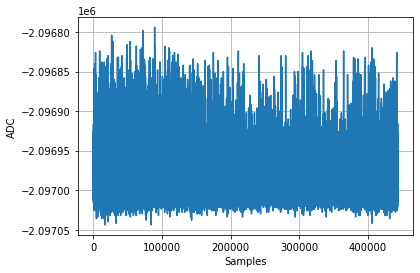

In [8]:
raw = tod.read('13.13_189.90B-I')
plt.plot(raw)
plt.grid()
plt.ylabel('ADC')
plt.xlabel('Samples')

In [6]:
hwp = sa_hwp.HWPSignalFilter(demod_modes=[0, 4], filter_modes=[], decimate_factor=1)
hwp.exec(sa_data)

In [7]:
mode = 4
x = raw
numtaps = hwp.numtaps
speed = 1.9970147901903104
b = 1.9
fs = 152.58787799982235
nyq = fs/2
nt = len(tod.read('bolo_time'))

In [8]:
#SETUP BAND PASS
fbpf = {}
pass_zero = speed * mode - b <= 0.
bpf = sa_cn.firwinc(numtaps,
              [-speed * (mode + b),
               -speed * (mode -b),
               speed * (mode - b),
               speed * (mode + b)],
              nyq=nyq, pass_zero=pass_zero)
fbpf[mode] = sa_cn.fftfilter(bpf, nt)

In [9]:
#SETUP LOW PASS
from scipy.signal import firwin
lpf = firwin(numtaps, speed * b, nyq=nyq, pass_zero=True)
flpf = sa_cn.fftfilter(lpf, nt)

Text(0.5, 0, 'Samples')

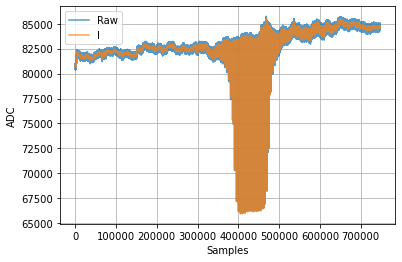

In [10]:
I = sa_cn.convolvefilter(x, numtaps, flpf).real
plt.plot(raw, label='Raw', alpha=0.75)
plt.plot(I, label='I', alpha=0.75)
plt.grid()
plt.legend()
plt.ylabel('ADC')
plt.xlabel('Samples')

Text(0.5, 1.0, 'Lowpass')

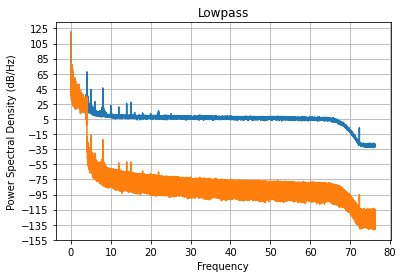

In [11]:
_,_ = plt.psd(raw, Fs=fs, NFFT=2**15)
_,_ = plt.psd(I, Fs=fs, NFFT=2**15)
plt.title('Lowpass')

In [12]:
#BAND PASS
bandpassed = sa_cn.convolvefilter(x-x.mean(), numtaps, fbpf[mode])

In [13]:
e = hwp.expangle[mode]
# e = np.conj(e)

u = np.ones(list(x.shape[:-1])+[1], x.dtype) * 2. * e
demodulated = u*bandpassed

In [14]:
#LOW PASS
lowpassed = sa_cn.convolvefilter(demodulated, numtaps, flpf)

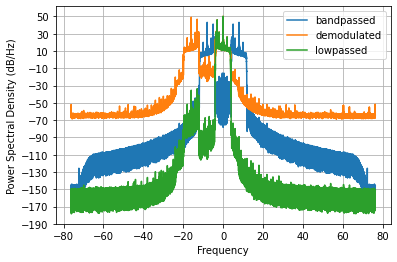

In [15]:
# _,_ = plt.psd(raw, Fs=fs, label='Raw')
_,_ = plt.psd(bandpassed, Fs=fs,  NFFT=2**15,label='bandpassed')
_,_ = plt.psd(demodulated, Fs=fs,  NFFT=2**15,label='demodulated')
_,_ = plt.psd(lowpassed, Fs=fs,  NFFT=2**15, label='lowpassed')
plt.legend()

In [16]:
# Q_positive = lowpassed.real
# U_positive = lowpassed.imag

In [17]:
# Q_negative = lowpassed.real
# U_negative = lowpassed.imag

In [18]:
# plt.plot(Q_positive-Q_negative, alpha=0.75, label = 'Q_negative - Q_positive')
# plt.plot(U_positive + U_negative, alpha=0.75, label = 'U_negative + U_positive')

# plt.grid()
# plt.legend()
# plt.ylabel('ADC')
# plt.xlabel('Samples')

In [19]:
from simons_array_python import sa_toast_pipeline_tools as sa_tpt

In [20]:
sa_tpt.setup_hwp(sa_data)

AttributeError: module 'simons_array_python.sa_toast_pipeline_tools' has no attribute 'setup_hwp'

In [21]:
data = sa_tpt.make_toast_data(args, comm, sa_data, sims_prefix=None)


NameError: name 'args' is not defined

In [20]:
import scipy as sp

In [68]:
t = np.linspace(0, 10, 1001)
nu = 2
psi = 0 

f = np.sin(2*np.pi*nu*t + psi)

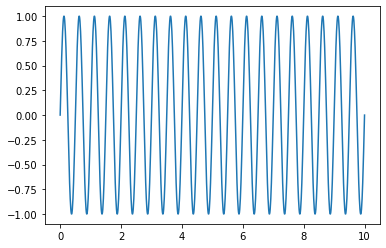

In [69]:
plt.plot(t, f)

In [71]:
rate = 1/np.mean(np.diff(t))
rate

100.0

In [75]:
freq = sp.fft.fftfreq(len(f), 1/rate)

(-5.0, 5.0)

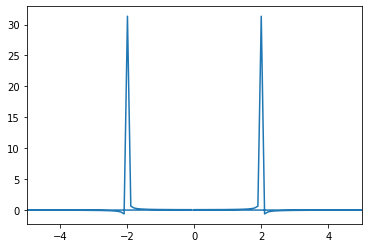

In [93]:
fft = sp.fft.fft(f)
plt.plot(freq, fft.real)
plt.xlim([-5, 5])

(-5.0, 5.0)

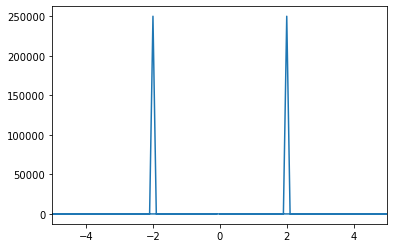

In [94]:
pxx = np.abs(fft)**2
plt.plot(freq, pxx)
plt.xlim([-5, 5])

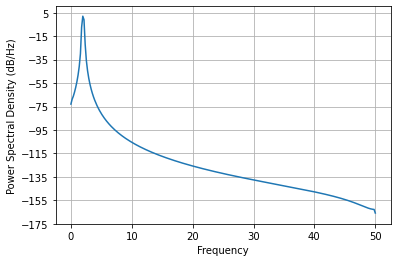

In [88]:
_,_=plt.psd(f, NFFT= 512,Fs=rate)